# Deep Learning code (Akanksha)

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

%matplotlib inline

In [2]:
data = pd.read_csv(Path("Resources/combined_data.csv"), thousands=',', index_col='Year')
data.drop(columns="Quarter", inplace=True)


In [3]:
data.head()

,Fraud Reporting Count,Net Operating Income(Billions),Lagged Fraud Reporting Count,Lagged Net Operating Income(Billions)
Year,,,,
2014,82364,36.8,NaN,NaN
2014,95516,39.8,82364.0,36.8
2014,94084,38.1,95516.0,39.8
2014,90868,36.0,94084.0,38.1
2015,90566,39.0,90868.0,36.0


## Random reproducibility used for protyping to run multiple experiments to evaluate the model. 

In [4]:
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

#### Feature `X` and Target `y` Data

Identified quarterly timeframe through the use of `window_data()` function, to create the features set `X` and the target vector `y`. We defined the window size '4' to represent the quarter timeframe and use the column of the Fraud Reporting Count for feature and target column; to allow the model to predict the Quartertly Number Fraud Instances and Net Income. 

In [5]:
def window_data(df, window, feature_col_number, target_col_number):
   
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Define the window size
window_size = 4

# Set the index of the feature and target columns
feature_column = [0, 1]
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[[8.2364e+04 3.6800e+01]
  [9.5516e+04 3.9800e+01]
  [9.4084e+04 3.8100e+01]
  [9.0868e+04 3.6000e+01]]

 [[9.5516e+04 3.9800e+01]
  [9.4084e+04 3.8100e+01]
  [9.0868e+04 3.6000e+01]
  [9.0566e+04 3.9000e+01]]

 [[9.4084e+04 3.8100e+01]
  [9.0868e+04 3.6000e+01]
  [9.0566e+04 3.9000e+01]
  [9.6365e+04 4.2600e+01]]] 

y sample values:
[[ 90566]
 [ 96365]
 [101745]]


# Split the Data Between Training and Testing Sets 

In [7]:
split = int(0.7 * len(X))

X_train = X[: split]

X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
display(X_train.shape)
display(y_train.shape)

(19, 4, 2)

(19, 1)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Fit scaler to reshaped X_Train
num_instances, num_time_steps, num_features = X_train.shape
X_train_reshaped = np.reshape(X_train, newshape=(-1, num_features))
scaler.fit(X_train_reshaped)

#Scale and reshape X_train to original shape
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = np.reshape(X_train_scaled, newshape=(num_instances, num_time_steps, num_features))

#Scale and reshape X_test to original shape
num_instances, num_time_steps, num_features = X_test.shape
X_test_reshaped = np.reshape(X_test, newshape=(-1, num_features))
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = np.reshape(X_test_scaled, newshape=(num_instances, num_time_steps, num_features))

#Fit scaler to y_train
scaler.fit(y_train)

#Scale y_train
y_train_scaled = scaler.transform(y_train)
#Scale y_test
y_test_scaled = scaler.transform(y_test)

In [10]:
display(X_train_scaled.shape)
display(y_train_scaled.shape)

(19, 4, 2)

(19, 1)

## Build and Train the LSTM RNN

In [11]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

2022-07-10 19:37:21.805434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 5)              160       
                                                                 
 dropout (Dropout)           (None, 4, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 5)              220       
                                                                 
 dropout_1 (Dropout)         (None, 4, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [14]:
model_history = model.fit(X_train_scaled, y_train_scaled, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
19/19 [==============================] - 6s 10ms/step - loss: 0.2273
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 0.1616
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.1118
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0822
Epoch 5/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0657
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0670
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0772
Epoch 8/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0939
Epoch 9/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0605
Epoch 10/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0853


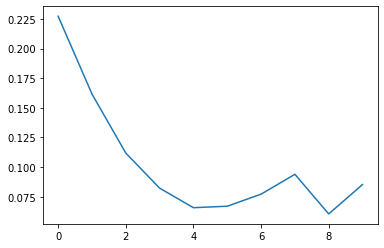

In [15]:
plt.plot(model_history.history["loss"])

In [16]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 48039149568.0000


48039149568.0

In [17]:
# Make some predictions
predicted = model.predict(X_test_scaled)

1/1 [==============================] - 2s 2s/step


In [18]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [19]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Year,,
2019,185082.0,136483.796875
2020,189439.0,135692.625000
2020,176864.0,133362.125000
2020,224264.0,127352.125000
2020,202986.0,121384.648438


<AxesSubplot:xlabel='Year'>

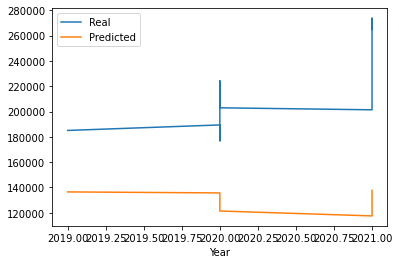

In [20]:
stocks.plot()

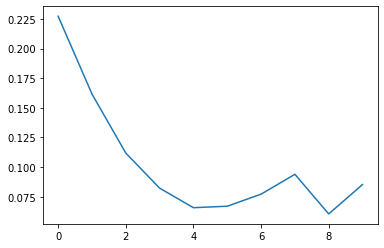

In [21]:
plt.plot(model_history.history["loss"])